In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization

## Viewing Static XES Spectra

In [2]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfx100894224',lcls_run=24)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['tt/fltpos_ps','epics/lxt', 'scan/mfx_lxt_fast1' , 'MfxDg2BmMon/totalIntensityJoules','tt/ampl'] 
names=['time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl']
#Here we define the epix detector keys separately as they are imported separately to avoid OOM
xes.key_epix=['epix100/ROI_area']
xes.friendly_name_epix=['epix']
##
xes.set_key_aliases(keys,names)
#xes.end_index=5000
xes.mintime=-87E-12
xes.maxtime=-85E-12
xes.numpoints=100
xes.time_bins=np.linspace(xes.mintime,xes.maxtime,xes.numpoints)
#xes.rois=[[0,50]]
xes.adu_cutoff=3.0
#xes.angle=90
xes.lxt_key=None
xes.transpose=False
#xes.add_filter('xray','ipm4',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
#xes.add_filter('simultaneous','time_tool_ampl',0.05)
xes.run_parser(['23'])

In [3]:
start=time.time()
xes.primary_analysis_parallel_range(8,xes_experiment,increment=1000,verbose=False)
end=time.time()

Processing: 100%|██████████| 13/13 [00:05<00:00,  2.29Shot_Batch/s]


Warning this dark will be based on ALL shots below a time index.


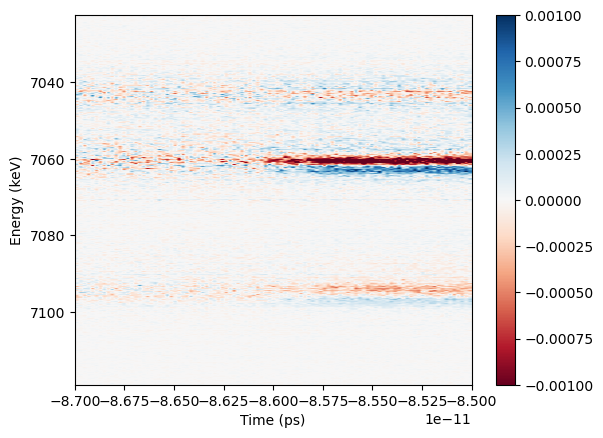

In [4]:
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_spectra(xes_analysis=xes,xes_key='epix_xray_not_laser_time_binned_ROI_1',xes_laser_key='epix_simultaneous_laser_time_binned_ROI_1',dark_cutoff=10)
v.vmin=-0.001
v.vmax=0.001
v.plot_2d_difference_spectrum(xes)
#plt.xlim(-0.8,0.8)
#print('Run 23 Laser on shots - Laser off shots')

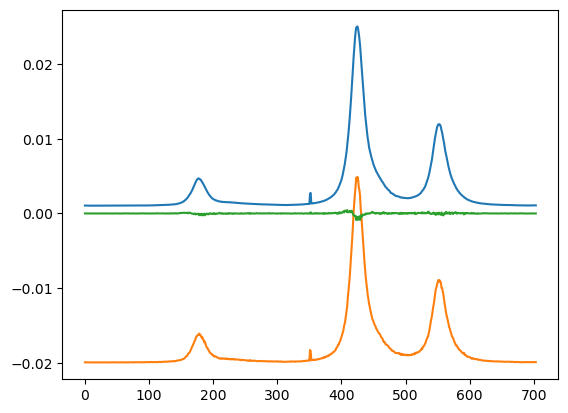

In [5]:
on=np.nanmean(v.summed_laser_on_normalized,axis=0)
off=np.nanmean(v.summed_laser_off_normalized,axis=0)
plt.plot(on+0.001)
plt.plot(off-0.02)
plt.plot(on-off)

Text(0, 0.5, '$\\Delta$ XES')

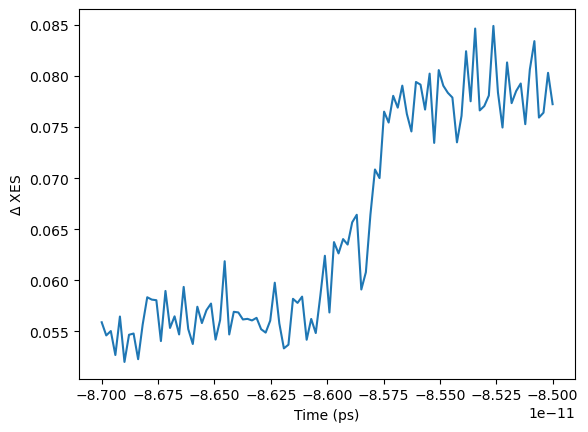

In [6]:
times=np.linspace(xes.mintime,xes.maxtime,xes.numpoints)
diff=np.nansum(np.abs(v.summed_laser_on_normalized-v.summed_laser_off_normalized),axis=1)[:-1]
plt.plot(times,diff)
plt.xlabel('Time (ps)')
plt.ylabel(r'$\Delta$ XES')


In [7]:
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
times=np.linspace(xes.mintime,xes.maxtime,xes.numpoints)
diff=np.nansum(np.abs(v.summed_laser_on_normalized-v.summed_laser_off_normalized),axis=1)[:-1]
smooth=False
interpolate=False
def error_function(x, a, b, c, d):
    return a * (1 + scipy.special.erf(b * (x - c))) + d

def gaussian(x, amplitude, center, fwhm, offset):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2)) + offset
initial_guess = [np.max(diff) - np.min(diff), 1E11, np.mean(times), np.min(diff)]
if interpolate:
    num_interpolated_points = len(times) * 10  # Increase the number of points by a factor of 10
    interpolator = interp1d(times, diff, kind='cubic', fill_value='extrapolate')
    times = np.linspace(times[0], times[-1], num_interpolated_points)
    diff = interpolator(times)

if smooth:
    diff=savgol_filter(diff, window_length=10, polyorder=9)
params, covariance = curve_fit(error_function, times, diff, p0=initial_guess, maxfev=99999999)

fig, axs = plt.subplots(2, 1, sharex=True, dpi=150)
fwhm = np.abs(2 * np.sqrt(2 * np.log(2)) / params[1])
grad = np.gradient(smoothed_diff, times[1] - times[0])
#grad = np.diff(diff) / np.diff(times)

axs[1].plot(times, grad, label='Data Gradient')
axs[0].plot(times, diff, label='Data')
axs[1].set_xlabel('Position')
axs[1].set_ylabel('Intensity')
# axs[0].set_title(f'Wire Scan Run {run}; Fitted FWHM = {fwhm*1000:,.3f} microns')
axs[1].plot(times,  gaussian(times, np.max(np.abs(grad)), params[2], fwhm, 0), label='Gaussian Fit')
axs[1].set_title('Derivative')

# Plot the error function fit
axs[0].plot(times, error_function(times, *params), label='Error Function Fit')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

print("Fitted parameters for the error function:")
#print(f"Amplitude (a): {params[0]} - This controls the vertical stretch of the error function.")
#print(f"Slope (b): {params[1]} - This influences the steepness of the transition edge.")
#print(f"Center (c): {params[2]} - This is the horizontal position of the center of the error function.")
#print(f"Offset (d): {params[3]} - This is the vertical offset of the error function.")
print(f"FWHM: {fwhm*1E15} - This is the full width at half maximum of the instrument response function (IRF).")


NameError: name 'scipy' is not defined